# Oil and Gas

## Figure 1

This data was directly obtained from Global Energy Monitor's Global Oil and Gas Extraction Tracker Report from Figure 5 [here](https://globalenergymonitor.org/report/oil-gas-extractions-move-offshore-trends-and-risks/).

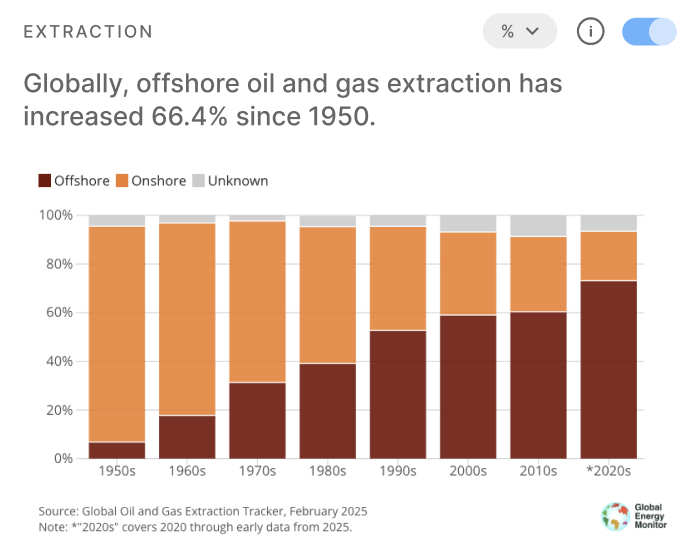

## Figure 2

This data was directly obtained from Global Energy Monitor's Global Oil and Gas Extraction Tracker Report from Figure 1 [here](https://globalenergymonitor.org/report/oil-gas-extractions-move-offshore-trends-and-risks/).

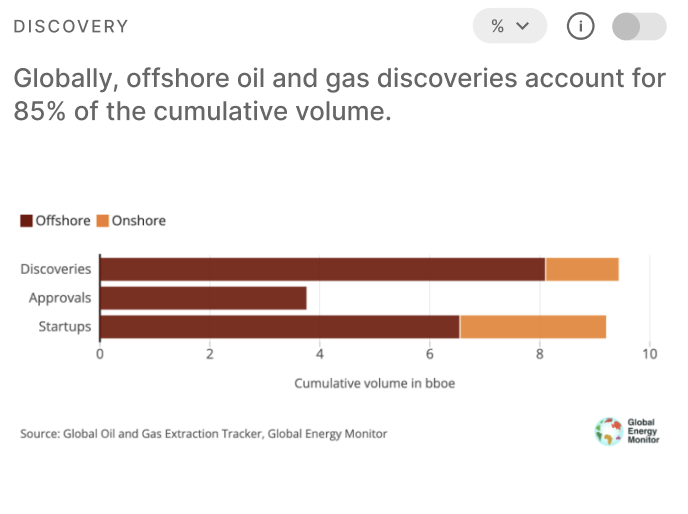

## Figure 3

This statistic is directly obtained from the Characteristics and Distributions of Global Oil and Gas Resources
chapter by Dou et al., 2024 [here](https://link.springer.com/chapter/10.1007/978-981-97-4756-6_3#:~:text=The%20remaining%20recoverable%20reserves%20of%20onshore%20oil%20and%20gas%20worldwide,3.5).

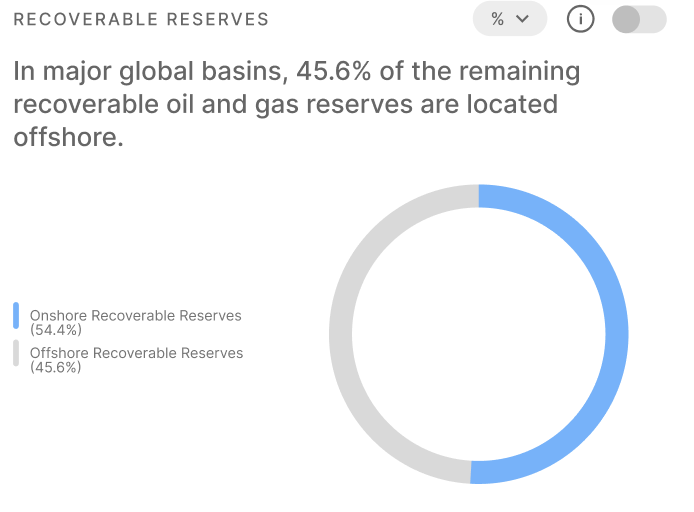

## Figure 4

The initial file for oil and gas extraction sites was obtained from Global Energy Monitor [here](https://globalenergymonitor.org/projects/global-oil-gas-extraction-tracker/download-data/).

In [ ]:
# Code for obtaining the geojson file from a csv

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Input / output paths
csv_path = "oil_extraction_GEM.csv"
geojson_path = "Fig_4_offshore_oil_points.geojson"

# Read CSV
df = pd.read_csv(csv_path)

# 1. Filter to only Offshore rows
offshore_df = df[df["Onshore/Offshore"] == "Offshore"].copy()

# 2. Build GeoDataFrame from Latitude / Longitude
geometry = [Point(xy) for xy in zip(offshore_df["Longitude"], offshore_df["Latitude"])]

gdf = gpd.GeoDataFrame(offshore_df, geometry=geometry, crs="EPSG:4326")  # WGS84

# 3. Save to GeoJSON (keeps all attributes)
gdf.to_file(geojson_path, driver="GeoJSON")

print(f"Saved Offshore points to {geojson_path}")

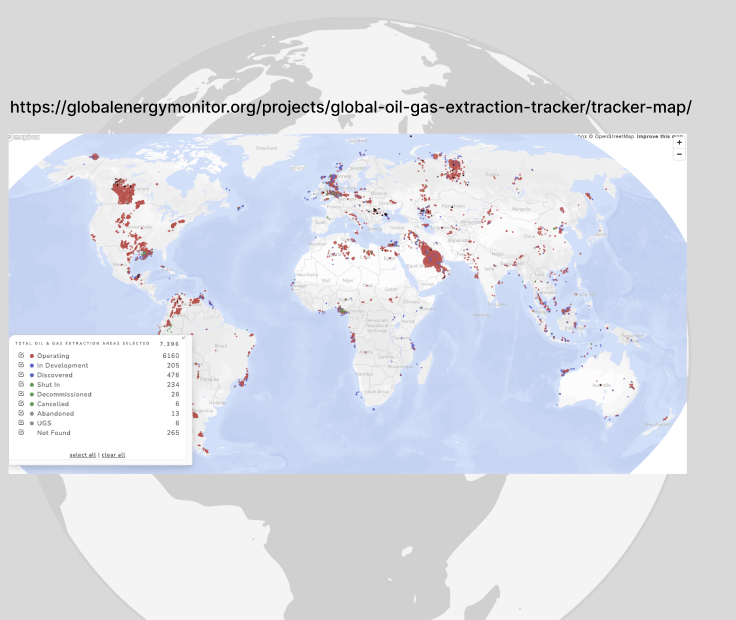

## Figure 5

A json file for this figure was created with approximate coordinates within each basin with the values from the bar chart. The source of this figure is here - Dou, L., Wen, Z., Wang, Z. (2024). Characteristics and Distributions of Global Oil and Gas Resources. In: Global Oil and Gas Resources: Potential and Distribution. Springer, Singapore. https://doi.org/10.1007/978-981-97-4756-6_3

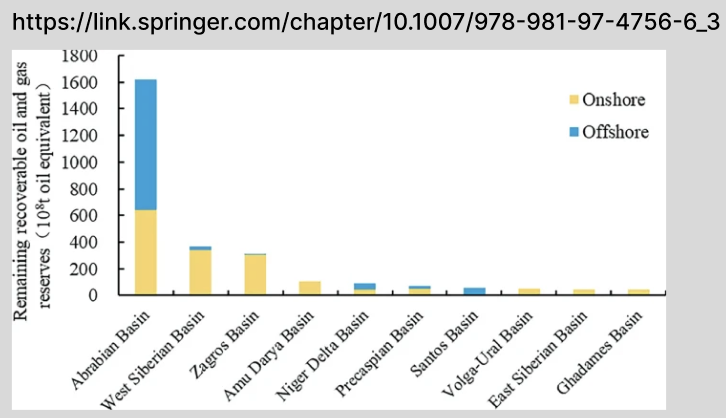

## Figure 6

This data was directly obtained from Our World in Data [here](https://ourworldindata.org/grapher/energy-consumption-by-source-and-country). The percentages were calculated for the 'World' rows using Excel and converted into a json by year.

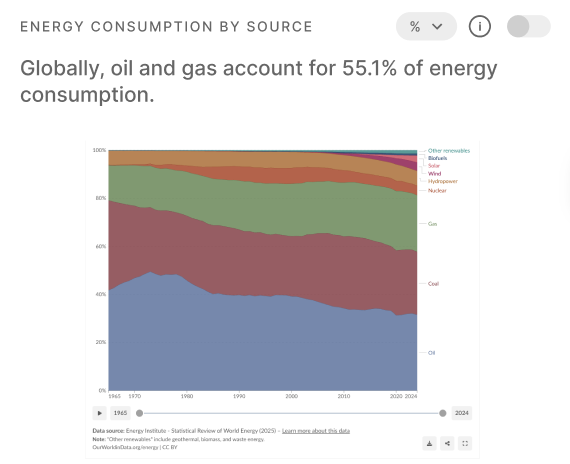

# Fig 7

In [ ]:
# Firstly, the oil + gas extraction points from the above geojson was intersected with the Masked 30 by 30 critical ecosystems tif

import geopandas as gpd
import rasterio
import numpy as np

tif_path = "masked_top_30_percent_over_water.tif"
pts_path = "Fig_3_offshore_points.geojson"
out_path = "Offshore_points_critical_areas.geojson"

with rasterio.open(tif_path) as src:
    gdf = gpd.read_file(pts_path)

    # If GeoJSON has no CRS, assume WGS84 (common for that structure)
    if gdf.crs is None:
        gdf = gdf.set_crs(epsg=4326)

    # Reproject to raster CRS
    gdf = gdf.to_crs(src.crs)

    # keep only valid, non-empty Points
    gdf = gdf[
        gdf.geometry.notnull()
        & ~gdf.geometry.is_empty
        & (gdf.geometry.geom_type == "Point")
    ].copy()

    # coords for sampling
    coords = [(geom.x, geom.y) for geom in gdf.geometry]

    # sample raster and build mask (assumes 1 band)
    vals = np.array([v[0] for v in src.sample(coords)])
    nodata = src.nodata
    mask = (~np.isnan(vals)) & (vals != nodata)

    gdf_filtered = gdf[mask]

gdf_filtered.to_file(out_path, driver="GeoJSON")

# write out
gdf_filtered.to_file(out_path, driver="GeoJSON")

# The total number of overlapping points = 1437 whereas the total offshore oil + gas extraction points = 1962
# The % of offshore oil and gas extraction in offshore areas over critical ecosystems = 73.24%

In [ ]:
# Next, the number of extraction points over marine regions overlapping critical ecosystems was calculated

import geopandas as gpd
import pandas as pd
import rasterio
import numpy as np

# -----------------------------
# 0. Input paths (edit as needed)
# -----------------------------
points_path = "Fig_4_offshore_points.geojson"
regions_path = "World_Seas_IHO_v3/World_Seas_IHO_v3.shp"
kba_raster_path = "masked_top_30_percent_over_water.tif"

# -----------------------------
# 1. Read input vector layers
# -----------------------------
points = gpd.read_file(points_path)
regions = gpd.read_file(regions_path)

# -----------------------------
# 2. Sample the GeoTIFF at point locations
#    -> create a boolean "in_kba" for each point
# -----------------------------
with rasterio.open(kba_raster_path) as src:
    # Reproject points to raster CRS for sampling
    points_kba_crs = points.to_crs(src.crs)

    # Build a mask of valid point geometries
    valid_geom = (
        points_kba_crs.geometry.notnull() &
        (~points_kba_crs.geometry.is_empty) &
        (points_kba_crs.geometry.geom_type == "Point")
    )

    # Prepare array for sampled values, default NaN
    sampled_values = np.full(len(points_kba_crs), np.nan, dtype="float64")

    # Only sample where geometry is valid
    valid_points = points_kba_crs.loc[valid_geom]

    coords = [(geom.x, geom.y) for geom in valid_points.geometry]

    if len(coords) > 0:
        # Sample raster at these coordinates
        samples = list(src.sample(coords))  # list of 1D arrays
        samples = np.array([v[0] for v in samples], dtype="float64")

        # Put sampled values back into the full-length array
        sampled_values[valid_geom.to_numpy()] = samples

    # Attach sampled values back to the *original* points GeoDataFrame
    points["kba_val"] = sampled_values

    # Determine nodata value, if any
    nodata = src.nodata

# Define what counts as "inside KBA":
# Here: non-nodata and > 0. Adjust if your raster’s scheme is different.
if nodata is not None:
    points["in_kba"] = (
        (points["kba_val"] != nodata) &
        np.isfinite(points["kba_val"]) &
        (points["kba_val"] > 0)
    )
else:
    points["in_kba"] = (
        np.isfinite(points["kba_val"]) &
        (points["kba_val"] > 0)
    )

# -----------------------------
# 3. Ensure points & regions share the same CRS for spatial join
# -----------------------------
if points.crs != regions.crs:
    points = points.to_crs(regions.crs)

# -----------------------------
# 4. Spatial join: assign each point to a marine region
# -----------------------------
joined = gpd.sjoin(
    points,
    regions[['NAME', 'ID', 'geometry']],  # keep only needed columns from regions
    how='inner',
    predicate='intersects'
)

# -----------------------------
# 5. Total sites per region (your existing summary)
# -----------------------------
counts_total = (
    joined
    .pivot_table(
        index='NAME',
        columns='Onshore/Offshore',  # your existing classification
        values='geometry',
        aggfunc='count',
        fill_value=0
    )
    .reset_index()
)

counts_total.columns.name = None  # flatten columns
counts_total['total_sites'] = counts_total.drop(columns=['NAME']).sum(axis=1)

# -----------------------------
# 6. Sites in critical_ecosystems per region
# -----------------------------

mask_kba = joined['in_kba'] == True

kba_counts = (
    joined[mask_kba]
    .groupby('NAME')
    .size()
    .reset_index(name='sites_in_kba')
)

# -----------------------------
# 7. Combine both summaries
# -----------------------------
final_counts = counts_total.merge(kba_counts, on='NAME', how='left')
final_counts['sites_in_kba'] = final_counts['sites_in_kba'].fillna(0).astype(int)

print(final_counts.head())

# Optionally: save to CSV
final_counts.to_csv("sites_per_region_with_kba_counts.csv", index=False)

# This csv provides the sites per marine region along with the sites overlapping critical ecosystems within the region

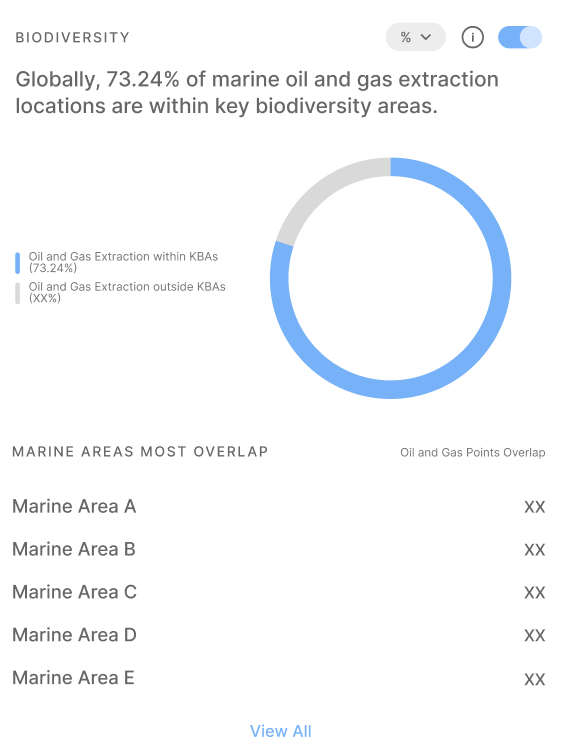

# Fig 8

The data underlying this image is provided by Rystad Energy. The image is derived from this [UN Report on Harmful Marine Extractives](https://www.unepfi.org/wordpress/wp-content/uploads/2022/04/Harmful-Marine-Extra-ctives_Offshore-Oil-Gas.pdf).

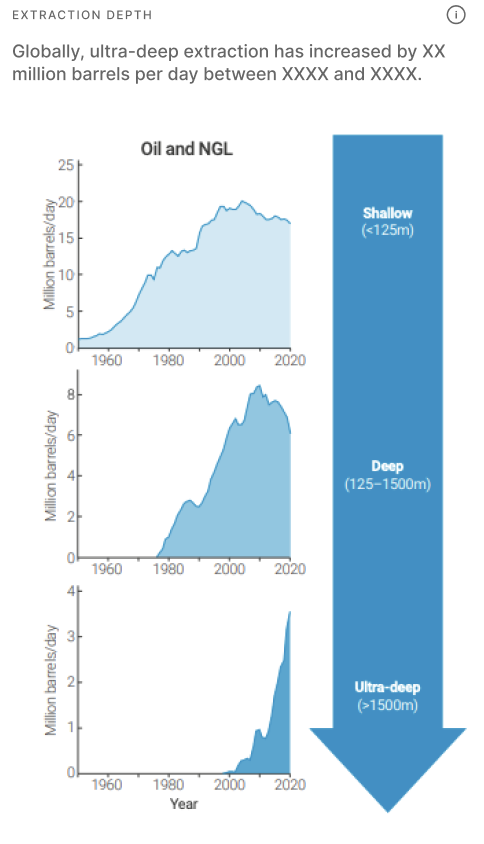